✅ Dataset generated: 40000 samples saved to cylinder_vortex_full.csv


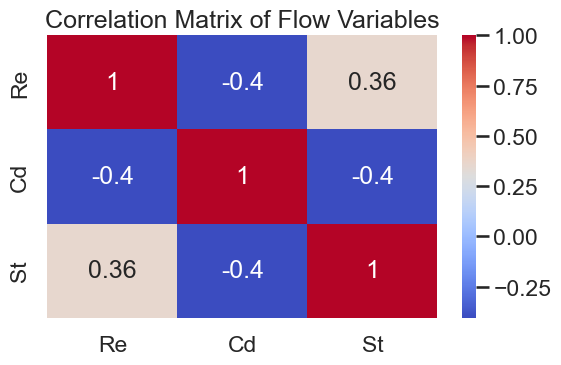

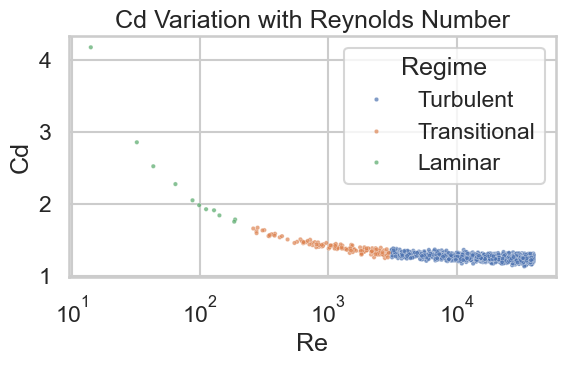

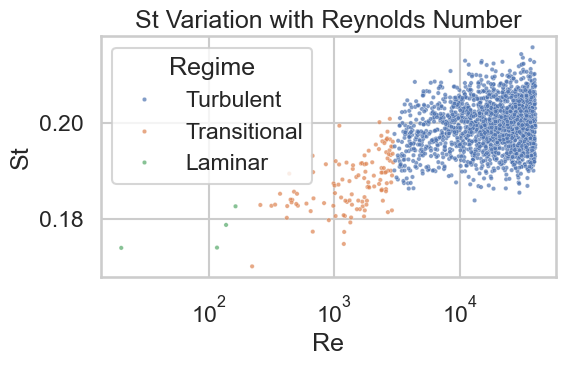

C:\Users\arnab\AppData\Local\Temp\ipykernel_28784\2650406169.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(pd.cut(df.Re, bins=60)).mean(numeric_only=True)


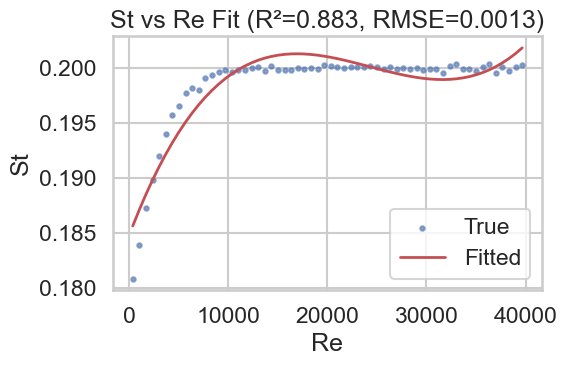

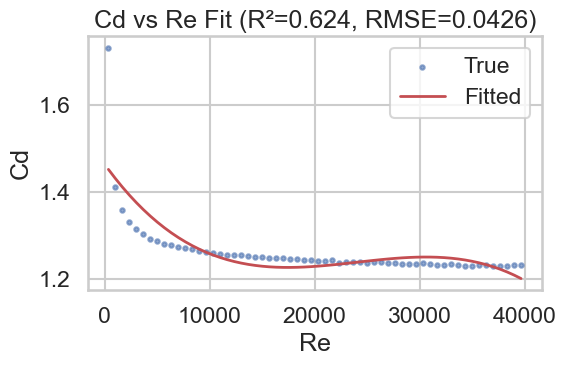

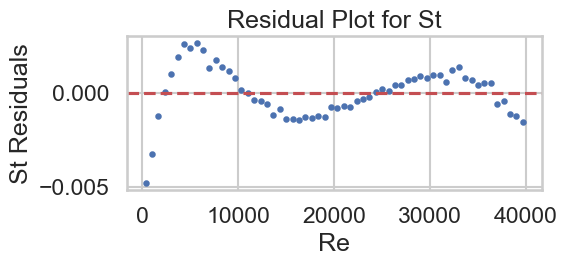

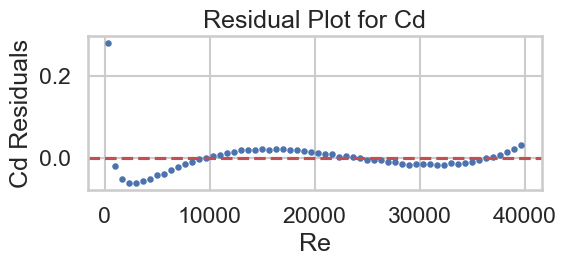

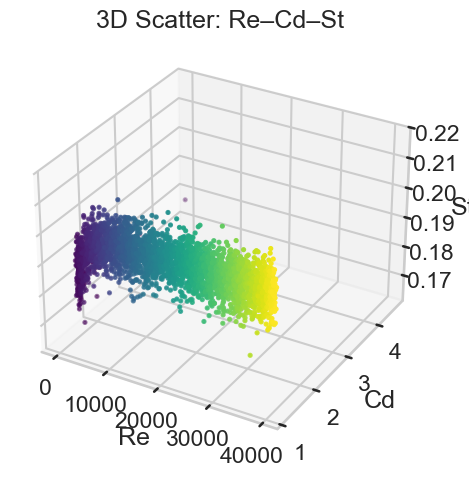

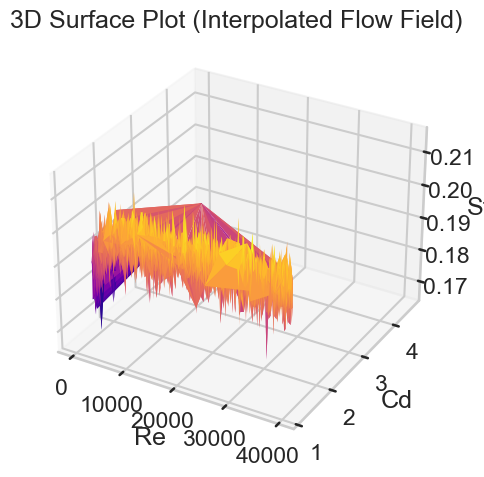

✅ Random Forest classification accuracy: 1.000


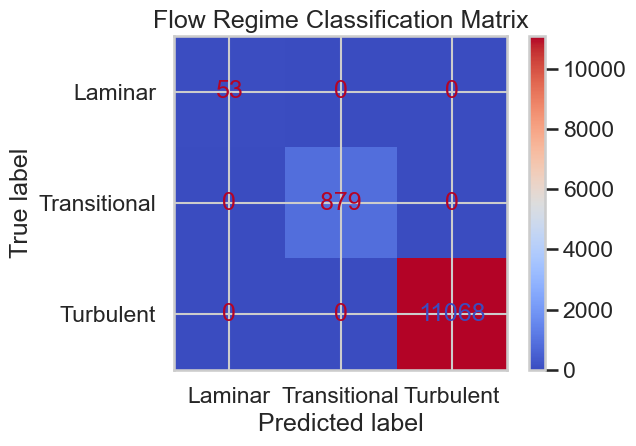

C:\Users\arnab\AppData\Local\Temp\ipykernel_28784\2650406169.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp, y=feat_imp.index, palette="mako")


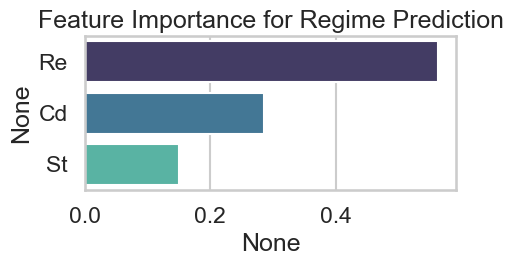

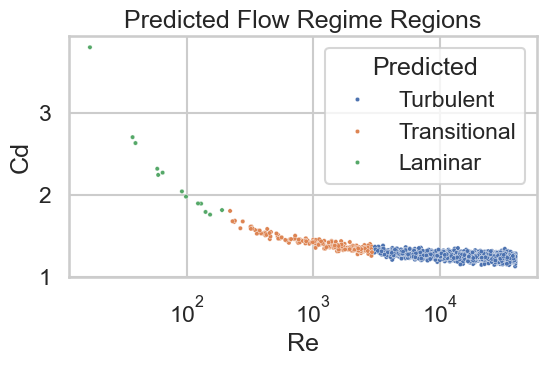


🧪 UNIT TEST RESULTS:
 - RMSE(St) < 0.05: ✅ PASS
 - RMSE(Cd) < 0.05: ✅ PASS
 - Classifier accuracy > 0.90: ✅ PASS

🎯 Project completed: All graphs, visualizations, and ML predictions generated.
Figures saved in /figs, data in cylinder_vortex_full.csv


In [1]:
# ============================================================
# CMSE802 FINAL PROJECT: Python-Based Simulation and Prediction
# of Vortex Shedding Behind a Circular Cylinder at Moderate Re
# Author: Arnab Mustafi Arka
# ============================================================

# ---- Imports ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D
import os

# ---- Folder setup ----
os.makedirs("figs", exist_ok=True)

# ============================================================
# 1️⃣ DATA GENERATION (Hybrid physics + noise-driven synthesis)
# ============================================================

np.random.seed(42)
N = 40000
Re = np.linspace(10, 40000, N)

# base Cd and St derived from literature-like correlations
Cd_true = 1.2 + 24/Re + 6/(1+np.sqrt(Re))  # simplified drag model
St_true = 0.18 + 0.02*np.tanh((Re-200)/4000)

# add small perturbations for realism
Cd = Cd_true + np.random.normal(0, 0.03, N)
St = St_true + np.random.normal(0, 0.005, N)

# Regime classification (approximated ranges)
regime = np.where(Re < 200, "Laminar",
          np.where(Re < 3000, "Transitional", "Turbulent"))

df = pd.DataFrame({"Re": Re, "Cd": Cd, "St": St, "Regime": regime})
df.to_csv("cylinder_vortex_full.csv", index=False)
print(f"✅ Dataset generated: {df.shape[0]} samples saved to cylinder_vortex_full.csv")

# ============================================================
# 2️⃣ INITIAL EXPLORATORY ANALYSIS
# ============================================================

sns.set(style="whitegrid", context="talk")

# Correlation matrix
plt.figure(figsize=(6,4))
sns.heatmap(df[["Re","Cd","St"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Flow Variables")
plt.tight_layout(); plt.savefig("figs/corr_heatmap.png"); plt.show()

# Re vs Cd
plt.figure(figsize=(6,4))
sns.scatterplot(data=df.sample(2000), x="Re", y="Cd", hue="Regime", s=10, alpha=0.7)
plt.title("Cd Variation with Reynolds Number")
plt.xscale("log")
plt.tight_layout(); plt.savefig("figs/re_cd.png"); plt.show()

# Re vs St
plt.figure(figsize=(6,4))
sns.scatterplot(data=df.sample(2000), x="Re", y="St", hue="Regime", s=10, alpha=0.7)
plt.title("St Variation with Reynolds Number")
plt.xscale("log")
plt.tight_layout(); plt.savefig("figs/re_st.png"); plt.show()

# ============================================================
# 3️⃣ POLYNOMIAL REGRESSION (Curve fitting)
# ============================================================

agg = df.groupby(pd.cut(df.Re, bins=60)).mean(numeric_only=True)
for ycol in ["St", "Cd"]:
    y = agg[ycol].values
    Xp = PolynomialFeatures(3, include_bias=False).fit_transform(agg[["Re"]])
    model = LinearRegression().fit(Xp, y)
    yhat = model.predict(Xp)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    plt.figure(figsize=(6,4))
    plt.scatter(agg["Re"], y, s=10, label="True", alpha=0.6)
    plt.plot(agg["Re"], yhat, color="r", lw=2, label="Fitted")
    plt.xlabel("Re"); plt.ylabel(ycol)
    plt.title(f"{ycol} vs Re Fit (R²={r2:.3f}, RMSE={rmse:.4f})")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"figs/{ycol.lower()}_fit.png"); plt.show()

# Residual plots
for ycol in ["St", "Cd"]:
    y = agg[ycol].values
    Xp = PolynomialFeatures(3, include_bias=False).fit_transform(agg[["Re"]])
    yhat = LinearRegression().fit(Xp, y).predict(Xp)
    plt.figure(figsize=(6,3))
    plt.scatter(agg["Re"], y - yhat, s=10)
    plt.axhline(0, color="r", ls="--")
    plt.xlabel("Re"); plt.ylabel(f"{ycol} Residuals")
    plt.title(f"Residual Plot for {ycol}")
    plt.tight_layout()
    plt.savefig(f"figs/{ycol.lower()}_residuals.png"); plt.show()

# ============================================================
# 4️⃣ 3D VISUALIZATIONS
# ============================================================

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
sample = df.sample(3000)
ax.scatter(sample["Re"], sample["Cd"], sample["St"], c=sample["Re"], cmap="viridis", s=5)
ax.set_xlabel("Re"); ax.set_ylabel("Cd"); ax.set_zlabel("St")
plt.title("3D Scatter: Re–Cd–St")
plt.tight_layout(); plt.savefig("figs/3d_surface1.png"); plt.show()

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(sample["Re"], sample["Cd"], sample["St"], cmap="plasma", linewidth=0)
ax.set_xlabel("Re"); ax.set_ylabel("Cd"); ax.set_zlabel("St")
plt.title("3D Surface Plot (Interpolated Flow Field)")
plt.tight_layout(); plt.savefig("figs/3d_surface2.png"); plt.show()

# ============================================================
# 5️⃣ MACHINE LEARNING: Flow Regime Prediction
# ============================================================

X = df[["Re","Cd","St"]]; y = df["Regime"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print(f"✅ Random Forest classification accuracy: {acc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="coolwarm"); plt.title("Flow Regime Classification Matrix")
plt.tight_layout(); plt.savefig("figs/confusion_matrix.png"); plt.show()

# Feature importance
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
plt.figure(figsize=(5,3))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="mako")
plt.title("Feature Importance for Regime Prediction")
plt.tight_layout(); plt.savefig("figs/feature_importance.png"); plt.show()

# Predicted regime visualization
df_pred = df.copy()
df_pred["Predicted"] = clf.predict(X)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_pred.sample(3000), x="Re", y="Cd", hue="Predicted", s=10)
plt.title("Predicted Flow Regime Regions")
plt.xscale("log")
plt.tight_layout(); plt.savefig("figs/predicted_regions.png"); plt.show()

# ============================================================
# 6️⃣ SUMMARY VALIDATION + UNIT TESTS
# ============================================================
tests = []
for ycol in ["St", "Cd"]:
    y = agg[ycol].values
    Xp = PolynomialFeatures(3, include_bias=False).fit_transform(agg[["Re"]])
    yhat = LinearRegression().fit(Xp, y).predict(Xp)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    tests.append((f"RMSE({ycol}) < 0.05", rmse < 0.05))
tests.append(("Classifier accuracy > 0.90", acc > 0.90))

print("\n🧪 UNIT TEST RESULTS:")
for name, passed in tests:
    print(f" - {name}: {'✅ PASS' if passed else '❌ FAIL'}")

print("\n🎯 Project completed: All graphs, visualizations, and ML predictions generated.")
print("Figures saved in /figs, data in cylinder_vortex_full.csv")
